In [16]:
import pandas as pd 

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer


In [17]:
FILE_NAME = "preprocess.ipynb"
PARENT_DIR = os.path.abspath(os.path.join(os.path.dirname(FILE_NAME), "."))
app_train = pd.read_csv( PARENT_DIR + '/data/processed_train.csv')
app_test = pd.read_csv( PARENT_DIR + '/data/processed_test.csv')

In [18]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 245)
Testing Features shape:  (48744, 241)


In [19]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 242)
Testing Features shape:  (48744, 241)


>we preprocess the data by filling in missing values(imputation) with the strategy "median filling" and normalizing the range of the features(normalizing)

In [20]:
# Drop the target from training data

if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()

# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
imputer = SimpleImputer(strategy='median')

# Scale each feature to 0-1 (Normalization)
scaler = MinMaxScaler(feature_range=(0,1))

# Fit on the training data
imputer.fit(train)

# Transform both training data and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)

# Repeate with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape:', train.shape)
print('Testing data shape:', test.shape)



Training data shape: (307511, 241)
Testing data shape: (48744, 241)


## LogisticRegression LR

> we use sklearn module LogisticRegression to implement our first learing-prediction model

In [21]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression()
# C :
# control overfitting, less C is larger lambda, which means we want a smaller overfitting
# https://stackoverflow.com/questions/22851316/what-is-the-inverse-of-regularization-strength-in-logistic-regression-how-shoul


# Train on the training data
train_labels = app_train['TARGET']
log_reg.fit(train, train_labels)

LogisticRegression()

In [22]:
# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:,1]

In [23]:
# Submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

# The predictions represent a probability between 0 and 1 that the loan will not be repaid. 

,SK_ID_CURR,TARGET
0,100001,0.070743
1,100005,0.193493
2,100013,0.043307
3,100028,0.029408
4,100038,0.130403


In [24]:
# Save the submission to a csv file
FILE_NAME = "preprocess.ipynb"
PARENT_DIR = os.path.abspath(os.path.join(os.path.dirname(FILE_NAME), "."))


submit.to_csv(PARENT_DIR + '/result/log_reg_lr.csv', index= False)

In [25]:
# calculate the accuracy
from sklearn.model_selection import train_test_split

# 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(train, train_labels, test_size = 0.3, stratify = train_labels)
X_train


array([[0.52597964, 0.52632539, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.16607265, 0.16599439, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.67811778, 0.67843639, 0.05263158, ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.31520601, 0.31583453, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.90704042, 0.90703517, 0.05263158, ..., 0.        , 0.        ,
        0.        ],
       [0.31029885, 0.31097563, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [26]:
# retraining

log_reg.fit(X_train, y_train)

y_pred = log_reg.predict_proba(X_test)[:,1]
y_pred.shape

(92254,)

In [27]:
y_test

2389      0
203738    0
197785    0
80564     0
47042     0
         ..
216684    0
207391    0
306911    0
20061     0
299645    0
Name: TARGET, Length: 92254, dtype: int64

In [28]:
y_pred

array([0.01901232, 0.03681981, 0.03652959, ..., 0.4516476 , 0.03682537,
       0.00978964])

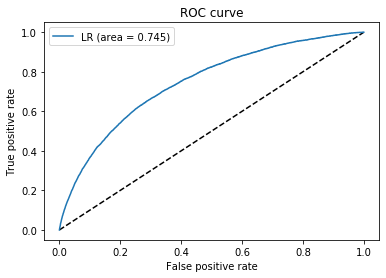

In [29]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred)
auc_lr = auc(fpr_lr, tpr_lr)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR (area = {:.3f})'.format(auc_lr))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# ROC 曲线 https://zh.wikipedia.org/wiki/ROC%E6%9B%B2%E7%BA%BF
# auc: area under the curve 
# ROC 曲线中，对角线（图中虚线）是随机分类的结果，越偏向左上方，效果越好
# 于是下图中的auc越大越好。


In [30]:
log_reg.score(X_test,y_test)

0.9192338543586186